# Numerai 253

Based on the official [tutorial](https://tit-btcqash.medium.com/a-comprehensive-guide-to-competing-at-numerai-70b356edbe07). Should not be groundbraking.

In [1]:
import os
import random as rn

import lightgbm as lgb
import matplotlib.pyplot as plt
import numerapi
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error

## Load Data

In [2]:
%%time

example_public_id = "WUTL537K2HLISXIDDHFTQF2LZ5MO67HV"
example_secret_key = "3EKVW2XQ7NTR6FDA77ZOJF4UWHOE56QYZ7VZ7CZ5WYVIMEARXEUNELYXOPH4S35J"
NAPI = numerapi.NumerAPI(example_public_id, example_secret_key)


DIR = "data"


def download_current_data(directory: str):
    """
        Downloads the data for the current round
        :param directory: The path to the directory where the data needs to be saved
        """
    current_round = NAPI.get_current_round()
    if os.path.isdir(f"{directory}/numerai_dataset_{current_round}/"):
        print(f"You already have the newest data! Current round is: {current_round}")
    else:
        print(f"Downloading new data for round: {current_round}!")
        NAPI.download_current_dataset(dest_path=directory, unzip=True)


def load_data(directory: str, reduce_memory: bool = True) -> tuple:
    """
        Get data for current round
        :param directory: The path to the directory where the data needs to be saved
        :return: A tuple containing the datasets
        """
    print("Loading the data")
    full_path = f"{directory}/numerai_dataset_{NAPI.get_current_round()}/"
    train_path = full_path + "numerai_training_data.csv"
    test_path = full_path + "numerai_tournament_data.csv"
    train = pd.read_csv(train_path, encoding='ascii')
    test = pd.read_csv(test_path, encoding='ascii')
    # Reduce all features to 32-bit floats
    if reduce_memory:
        num_features = [f for f in train.columns if f.startswith("feature")]
        train[num_features] = train[num_features].astype(np.float32)
        test[num_features] = test[num_features].astype(np.float32)
    val = test[test["data_type"] == "validation"]
    test = test[test["data_type"] != "validation"]
    return train, val, test


# Download, unzip and load data
download_current_data(DIR)
train, val, test = load_data(DIR, reduce_memory=True)

You already have the newest data! Current round is: 253
Loading the data
CPU times: user 1min 26s, sys: 59.3 s, total: 2min 26s
Wall time: 2min 28s


## Feature engineering

First of all, if you look at the train data, you can see that it is roughly divided into 6 types: “feature_intelligence”, “feature_wisdom”, “feature_charisma”, “feature_dexterity”, “feature_strength”, and “feature_constitution”.

I quote the code from Carlo Lepelaars’s article, but the mean, deviation, skewness, etc. of these features are useful features.Therefore, call train = get_group_stats (train) to add these features to the train data and so on.

If you have a PC with plenty of memory, it will be a good feature amount if you include feature difference data, interaction feature amount, etc. (Corr will increase by about 20%). When I run on Google Colab, it crashes, so I will post only the code. There are discussions in the forum about how to reduce this.

## Model

### LightGBM

In [3]:
meta = ['id', 'era', 'data_type', 'target', 'prediction']
feature_columns = [c for c in train.columns if c not in meta]

In [4]:
len(feature_columns)

310

In [5]:
%%time

dtrain = lgb.Dataset(train[feature_columns].fillna(0), label=train["target"])
dvalid = lgb.Dataset(val[feature_columns].fillna(0), label=val["target"])

best_config ={
    'boosting_type': 'gbdt',
    "objective": "regression",
    "num_leaves": 31,
    'min_data_in_leaf':1000,
    "learning_rate": 0.01,
    "n_estimators": 2000,
    "max_depth": 5,
    "metric": ["l2", "l1", "quantile"],
    "verbosity": 10,
    "random_state": 0,
    "device": "gpu",
    "lambda_l2": 0.1
} 

model = lgb.train(best_config, dtrain)

train.loc[:, "prediction"] = model.predict(train[feature_columns])

val.loc[:,"prediction"]=val["target"]
val.loc[:,"prediction"] = model.predict(val[feature_columns])

/home/jarutis/miniconda3/envs/nmr/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.792150
[LightGBM] [Info] Total Bins 1550
[LightGBM] [Info] Number of data points in the train set: 501808, number of used features: 310
[LightGBM] [Info] Using GPU Device: GeForce GTX 1080 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 308 dense feature groups (74.66 MB) transferred to GPU in 0.044023 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.499997
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 5
[LightGBM] [

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

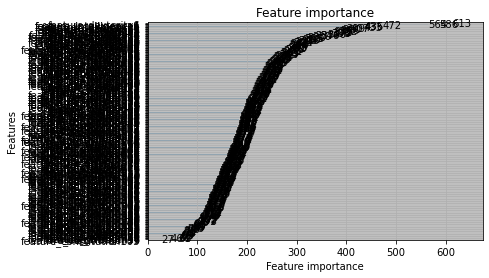

In [6]:
lgb.plot_importance(model)

## Evaluation

In [7]:
def sharpe_ratio(corrs: pd.Series) -> np.float32:
        """
        Calculate the Sharpe ratio for Numerai by using grouped per-era data

        :param corrs: A Pandas Series containing the Spearman correlations for each era
        :return: A float denoting the Sharpe ratio of your predictions.
        """
        return corrs.mean() / corrs.std()


def evaluate(df: pd.DataFrame) -> tuple:
        """
        Evaluate and display relevant metrics for Numerai 

        :param df: A Pandas DataFrame containing the columns "era", "target" and a column for predictions
        :param pred_col: The column where the predictions are stored
        :return: A tuple of float containing the metrics
        """
        def _score(sub_df: pd.DataFrame) -> np.float32:
            """Calculates Spearman correlation"""
            return spearmanr(sub_df["target"], sub_df["prediction"])[0]

        # Calculate metrics
        corrs = df.groupby("era").apply(_score)
        print(corrs)
        payout_raw = (corrs / 0.2).clip(-1, 1)
        spearman = round(corrs.mean(), 4)

        payout = round(payout_raw.mean(), 4)
        numerai_sharpe = round(sharpe_ratio(corrs), 4)
        mae = mean_absolute_error(df["target"], df["prediction"]).round(4)

        # Display metrics
        print(f"Spearman Correlation: {spearman}")
        print(f"Average Payout: {payout}")
        print(f"Sharpe Ratio: {numerai_sharpe}")
        print(f"Mean Absolute Error (MAE): {mae}")
        return spearman, payout, numerai_sharpe, mae
        
feature_spearman_val = [spearmanr(val["prediction"], val[f])[0] for f in feature_columns]
feature_exposure_val = np.std(feature_spearman_val).round(4)
spearman, payout, numerai_sharpe, mae = evaluate(val)

era
era121    0.018123
era122    0.024992
era123    0.036392
era124    0.059945
era125    0.041519
era126    0.015844
era127   -0.003361
era128    0.050617
era129   -0.023012
era130    0.046300
era131    0.032234
era132    0.078740
era197    0.030059
era198    0.027132
era199   -0.027213
era200    0.019230
era201    0.022055
era202    0.030362
era203    0.026173
era204    0.031433
era205   -0.003093
era206    0.004292
era207    0.069304
era208    0.036244
era209    0.035491
era210   -0.019291
era211   -0.000329
era212    0.028212
dtype: float64
Spearman Correlation: 0.0246
Average Payout: 0.1229
Sharpe Ratio: 0.9572
Mean Absolute Error (MAE): 0.155


## Submission CSV

In [9]:
feature_list = feature_columns

test.loc[:, "prediction"] =0
test.loc[:, "prediction"] = model.predict(test[feature_list])
test[['id', "prediction"]].to_csv("submission_test.csv", index=False)

val[['id', "prediction"]].to_csv("submission_val.csv", index=False)

test=0
val=0

directory = "data"
full_path = f'{directory}/numerai_dataset_{NAPI.get_current_round()}/'

test_path = full_path + 'numerai_tournament_data.csv'

tournament_data = pd.read_csv(test_path)
tournament_data_id=tournament_data['id']
tournament_data_id2=tournament_data['feature_dexterity7']
tournament_data_id=pd.concat([tournament_data_id,tournament_data_id2],axis=1)

val=pd.read_csv("submission_val.csv")
test=pd.read_csv("submission_test.csv")

test_val_concat=pd.concat([val[['id', "prediction"]],test[['id', "prediction"]]],axis=0).set_index('id')
tournament_data_id=tournament_data_id.set_index('id')

conc_submit=pd.concat([tournament_data_id,test_val_concat],axis=1).drop(columns='feature_dexterity7').reset_index()
conc_submit=conc_submit.rename(columns={'index': 'id'})
conc_submit.to_csv("submission_file"+".csv", index=False)

In [10]:
def neutralize(series,by, proportion):
    scores = series.values.reshape(-1, 1)
    exposures = by.values.reshape(-1, 1)
    exposures = np.hstack((exposures, np.array([np.mean(series)] * len(exposures)).reshape(-1, 1)))
    correction = proportion * (exposures.dot(np.linalg.lstsq(exposures, scores)[0]))
    corrected_scores = scores - correction
    neutralized = pd.Series(corrected_scores.ravel(), index=series.index)
    return neutralized
    
by=pd.read_csv('data/numerai_dataset_'+str(NAPI.get_current_round())+'/example_predictions.csv')

neut=pd.read_csv("submission_file.csv")
neut=pd.DataFrame({'prediction':neutralize(neut['prediction'],by['prediction'], 0.3)})

conc=pd.concat([by.drop(columns="prediction"),neut],axis=1)
conc.to_csv("neutralized_submission_file.csv", index=False)#submission file

<ipython-input-10-db7083cc578f>:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  correction = proportion * (exposures.dot(np.linalg.lstsq(exposures, scores)[0]))
